In [13]:
import sys, os
sys.path.append('/user_data/mmhender/imStat/code/')
from feature_extraction import analyze_st_feats
from utils import default_paths
folder = os.path.join(default_paths.sketch_token_feat_path, 'cluster_ims')
file_list = [os.path.join(folder,'clust%d.png'%ii) for ii in range(150)]
curvrect_score= analyze_st_feats.CurvRectValues()
curvrect_score.process_images(file_list)

  0%|          | 0/8 [00:00<?, ?it/s]

processing 150 images...


100%|██████████| 8/8 [07:14<00:00, 48.64s/it]


In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [15]:
# Load the saved results of the analysis
dfname = '/user_data/mmhender/features/sketch_tokens/cluster_ims_curv_rect_values.csv'
df = pd.read_csv(dfname)
curv_values = np.array(df['best_bend'])
orient_values = np.array(df['best_orient']*180/np.pi)
df

,files,best_scale,best_bend,best_orient
0,/user_data/mmhender/features/sketch_tokens/clu...,0.098175,0.0000,1.658063
1,/user_data/mmhender/features/sketch_tokens/clu...,0.098175,0.0000,3.141593
2,/user_data/mmhender/features/sketch_tokens/clu...,0.098175,0.0000,1.308997
3,/user_data/mmhender/features/sketch_tokens/clu...,0.098175,0.0000,4.625123
4,/user_data/mmhender/features/sketch_tokens/clu...,0.098175,0.0000,0.349066
...,...,...,...,...
145,/user_data/mmhender/features/sketch_tokens/clu...,0.098175,0.0000,3.141593
146,/user_data/mmhender/features/sketch_tokens/clu...,0.098175,0.0025,4.712389
147,/user_data/mmhender/features/sketch_tokens/clu...,0.098175,0.0025,1.745329
148,/user_data/mmhender/features/sketch_tokens/clu...,0.098175,0.0000,4.712389


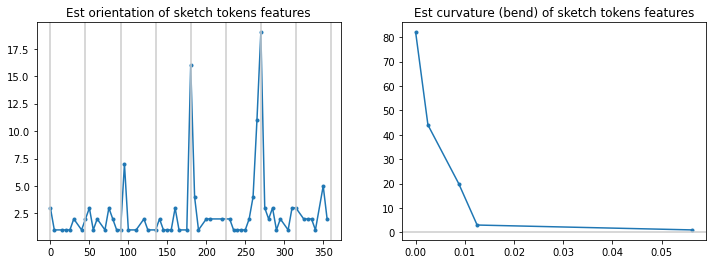

In [11]:
plt.figure(figsize=(12,4));
plt.subplot(1,2,1)
unvals, counts = np.unique(orient_values, return_counts=True)
plt.plot(unvals, counts,'.-')
for ii in np.arange(0,361,45):
    plt.axvline(ii, color=[0.8, 0.8, 0.8]);
plt.title('Est orientation of sketch tokens features');
plt.subplot(1,2,2)
unvals, counts = np.unique(curv_values, return_counts=True)
plt.plot(unvals, counts,'.-')
plt.axhline(0, color=[0.8, 0.8, 0.8]);
plt.title('Est curvature (bend) of sketch tokens features');

Text(0.5, 1.0, 'Curved features only')

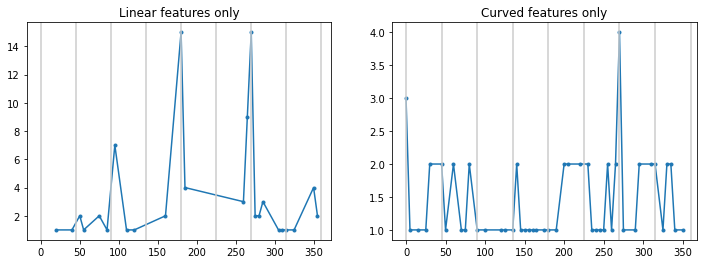

In [12]:
plt.figure(figsize=(12,4));
plt.subplot(1,2,1)
unvals, counts = np.unique(orient_values[curv_values==0], return_counts=True)
plt.plot(unvals, counts,'.-')
for ii in np.arange(0,361,45):
    plt.axvline(ii, color=[0.8, 0.8, 0.8]);
plt.title('Linear features only');
plt.subplot(1,2,2)
unvals, counts = np.unique(orient_values[curv_values>0], return_counts=True)
plt.plot(unvals, counts,'.-')
for ii in np.arange(0,361,45):
    plt.axvline(ii, color=[0.8, 0.8, 0.8]);
plt.title('Curved features only')

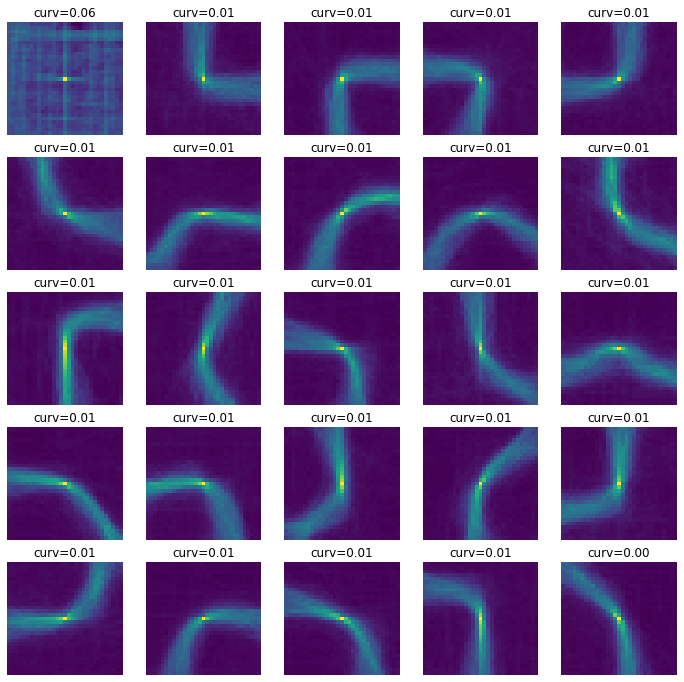

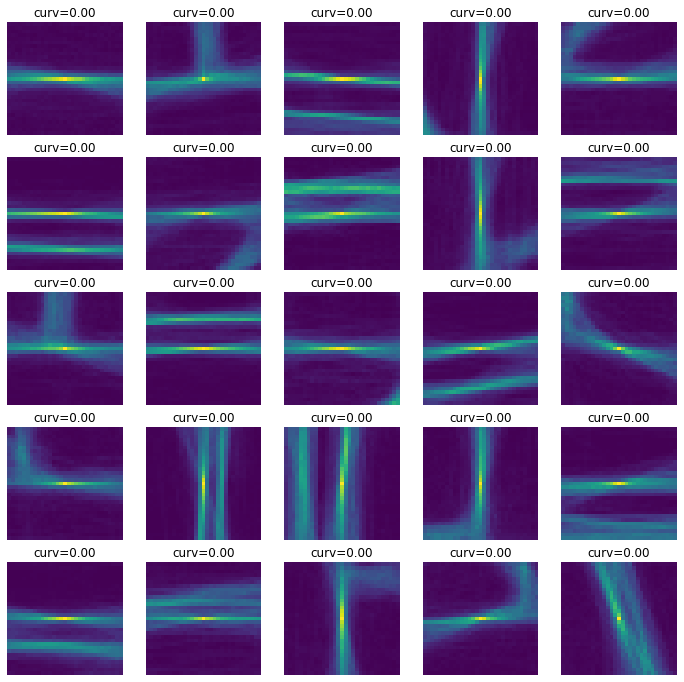

In [7]:
# Plot some examples of high curvature/low curvature
from scipy.io import loadmat
cluster_fn = os.path.join('/user_data/mmhender/toolboxes/SketchTokens/', 'clusters.mat')
clust = loadmat(cluster_fn)
feature_ims = clust['clusters']['clusters'][0][0]

ims2plot_list = [np.flip(np.argsort(curv_values))[0:25], np.argsort(curv_values)[0:25]]
for ims2plot in ims2plot_list:

    plt.figure(figsize=(12,12));
    for ii, im in enumerate(ims2plot):
        plt.subplot(5,5,ii+1)
        plt.pcolormesh(feature_ims[:,:,im])
        plt.gca().invert_yaxis()
        plt.axis('off')
    #     plt.axis('square')
        plt.title('curv=%.2f'%curv_values[im])

In [18]:
# Now going to visualize how the analysis works/what the kernels and images look like

rect_kernel_list = curvrect_score.kernels['rect_freq']
rect_spat_kernel_list = curvrect_score.kernels['rect_space']
curv_kernel_list = curvrect_score.kernels['curv_freq']
curv_spat_kernel_list = curvrect_score.kernels['curv_space']

curv_kernel_pars = curvrect_score.curv_kernel_pars
rect_kernel_pars = curvrect_score.rect_kernel_pars
all_kernel_pars = np.concatenate([rect_kernel_pars, curv_kernel_pars], axis=0)

all_kernels = np.concatenate([np.dstack(rect_kernel_list), np.dstack(curv_kernel_list)], axis=2)
all_spat_kernels = np.concatenate([np.dstack(rect_spat_kernel_list), np.dstack(curv_spat_kernel_list)], axis=2)

# all_kernels = all_kernels/np.max(np.max(all_kernels,axis=0), axis=0)

In [24]:
# This is the same computation that happens in the analysis, want to visualize some intermediate stages

batch = 0
images = np.dstack(curvrect_score.images[batch])
fft_images = np.dstack(curvrect_score.fft_images[batch])

"""calcuate kernel norm for normalization"""
all_kernels_power =  np.einsum('ijk,ijk->k',np.abs(all_kernels),np.abs(all_kernels))
all_kernels_power =  np.sqrt(all_kernels_power)

"""stack fft image list to a 3d array"""
all_conved_images = np.abs(np.fft.ifft2(fft_images[:,:,np.newaxis,:]*all_kernels[:,:,:,np.newaxis],axes=(0,1)))
all_conved_images = np.power(all_conved_images,1/2) ## power correction
all_conved_images = all_conved_images/all_kernels_power[np.newaxis, np.newaxis,:,np.newaxis]

# take max of each convolved image, and choose which kernel gave the biggest max activation.
max_each_kernel = np.max(np.max(all_conved_images, 0),0)
best_kernel_each_image = np.argmax(max_each_kernel, axis=0)

        

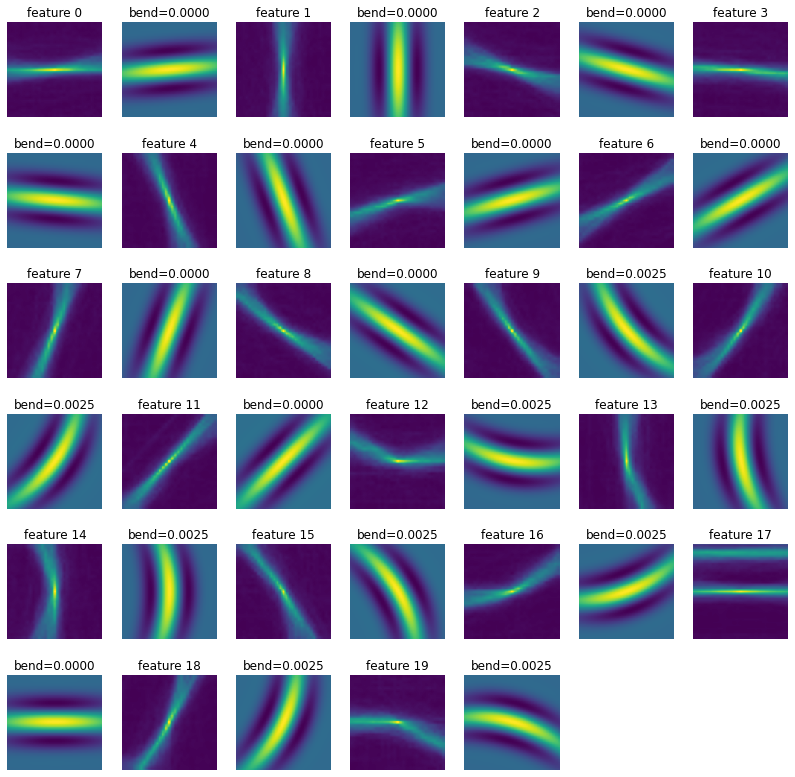

In [25]:
# Plot each image alongside its best spatial kernel

plt.figure(figsize=(14,14));
pi=0
for ii in range(20):
    pi+=1
    plt.subplot(6,7,pi)
    plt.pcolormesh(images[:,:,ii])
    plt.axis('off')
    plt.axis('square')
    plt.title('feature %d'%ii)
    pi+=1
    plt.subplot(6,7,pi)
    plt.pcolormesh(all_spat_kernels[:,:,best_kernel_each_image[ii]])
    plt.axis('off')
    plt.axis('square')
    plt.title('bend=%.4f'%all_kernel_pars[best_kernel_each_image[ii],1])

In [19]:
# This is the same computation that happens in the analysis, want to visualize some intermediate stages

batch = 5
images = np.dstack(curvrect_score.images[batch])
fft_images = np.dstack(curvrect_score.fft_images[batch])

"""calcuate kernel norm for normalization"""
all_kernels_power =  np.einsum('ijk,ijk->k',np.abs(all_kernels),np.abs(all_kernels))
all_kernels_power =  np.sqrt(all_kernels_power)

"""stack fft image list to a 3d array"""
all_conved_images = np.abs(np.fft.ifft2(fft_images[:,:,np.newaxis,:]*all_kernels[:,:,:,np.newaxis],axes=(0,1)))
all_conved_images = np.power(all_conved_images,1/2) ## power correction
all_conved_images = all_conved_images/all_kernels_power[np.newaxis, np.newaxis,:,np.newaxis]

# take max of each convolved image, and choose which kernel gave the biggest max activation.
max_each_kernel = np.max(np.max(all_conved_images, 0),0)
best_kernel_each_image = np.argmax(max_each_kernel, axis=0)

        

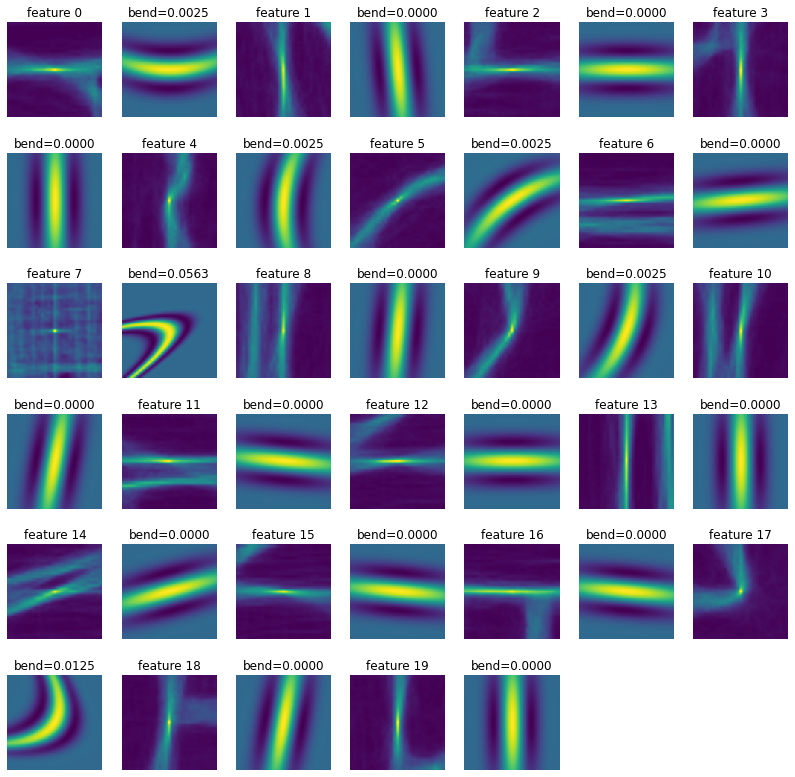

In [20]:
# Plot each image alongside its best spatial kernel

plt.figure(figsize=(14,14));
pi=0
for ii in range(20):
    pi+=1
    plt.subplot(6,7,pi)
    plt.pcolormesh(images[:,:,ii])
    plt.axis('off')
    plt.axis('square')
    plt.title('feature %d'%ii)
    pi+=1
    plt.subplot(6,7,pi)
    plt.pcolormesh(all_spat_kernels[:,:,best_kernel_each_image[ii]])
    plt.axis('off')
    plt.axis('square')
    plt.title('bend=%.4f'%all_kernel_pars[best_kernel_each_image[ii],1])

[510 114  78  79 115 511 509 512  77]


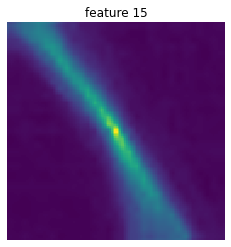

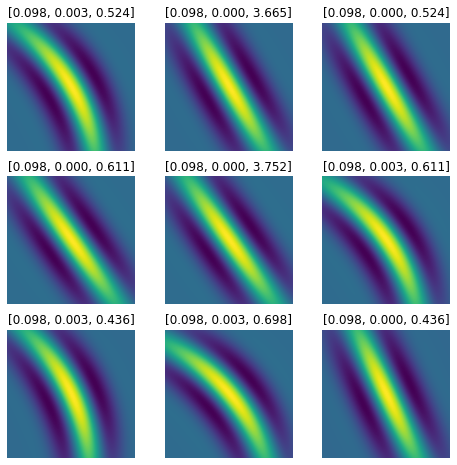

In [26]:
# Plot an example image and its top n kernels

ii=15

plt.figure();
plt.pcolormesh(images[:,:,ii])
plt.axis('off')
plt.axis('square')
plt.title('feature %d'%ii)

n2plot = 9
max_each_kernel = np.max(np.max(all_conved_images, axis=0), axis=0)
best_kernels = np.flip(np.argsort(max_each_kernel[:,ii]))[0:n2plot]

print(best_kernels)
plt.figure(figsize=(8,8));
for ii, ki in enumerate(best_kernels):
    plt.subplot(3,3,ii+1)
    plt.pcolormesh(all_spat_kernels[:,:,ki])
    plt.axis('off')
    plt.axis('square')
#     plt.colorbar()
    plt.title('[%.3f, %.3f, %.3f]'%(all_kernel_pars[ki,0],all_kernel_pars[ki,1],all_kernel_pars[ki,2]))

Text(0.5, 1.0, 'mult spatial domain')

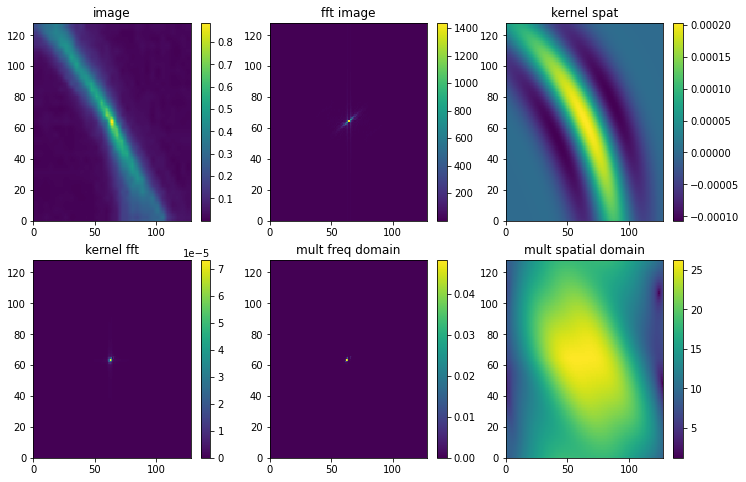

In [28]:
# For an example image and kernel, visualize all stages of convolution

ii=15
ki=510

plt.figure(figsize=(12,8));
plt.subplot(2,3,1)
plt.pcolormesh(images[:,:,ii])
plt.colorbar()
plt.title('image')
plt.subplot(2,3,2)
plt.pcolormesh(np.fft.fftshift(np.abs(fft_images[:,:,ii])))
plt.colorbar()
plt.title('fft image')
plt.subplot(2,3,3)
plt.pcolormesh(all_spat_kernels[:,:,ki])
plt.colorbar()
plt.title('kernel spat')
plt.subplot(2,3,4)
plt.pcolormesh(np.fft.fftshift(np.abs(all_kernels[:,:,ki])))
plt.colorbar()
plt.title('kernel fft')
plt.subplot(2,3,5)
plt.pcolormesh(np.abs(np.fft.fftshift(all_kernels[:,:,ki]*fft_images[:,:,ii])))
plt.colorbar()
plt.title('mult freq domain')
plt.subplot(2,3,6)
plt.pcolormesh(np.fft.fftshift(all_conved_images[:,:,ki,ii]))
# plt.pcolormesh(np.abs(np.fft.fftshift(np.fft.ifft2(all_kernels[:,:,ki]*fft_images[:,:,ii]))))
plt.colorbar()
plt.title('mult spatial domain')